## Import Required Libraries

In [3]:
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline
import itertools
import warnings
warnings.filterwarnings("ignore")
import datetime
import math
from prophet import Prophet


## Import the CSV Data

In [4]:
#df_all = pd.read_csv('C:/Users/priygupta/BYOP/CPG_Master_data_Set.csv', index_col=3)
df_all = pd.read_csv('C:/Users/priygupta/BYOP/CPG_Master_data_Set.csv')
print(df_all.head())

   Invoice  Product_Code  Quantity InvoiceDate InvoiceDate_timeStamp  Price  \
0    89058       7259395         3  20-04-2019      20-04-2019 06:02     62   
1    89058         10557         5  20-04-2019      20-04-2019 06:02     37   
2    89058       2733507         3  20-04-2019      20-04-2019 06:02     48   
3    89058       5200349         5  20-04-2019      20-04-2019 06:02    100   
4    89058        715497         3  20-04-2019      20-04-2019 06:02     91   

   Customer_ID Country  Pack_Size_Code  In_Store_Promotion_Flag  \
0        38055     USA               3                        0   
1        38055     USA               3                        1   
2        38055     USA               1                        1   
3        38055     USA               4                        1   
4        38055     USA               2                        1   

   Online_Promotion_Flag  Shelf_Space_Code  
0                      0                 3  
1                      0        

## Format the date 

In [5]:

df_all['InvoiceDate'] = pd.to_datetime(df_all['InvoiceDate'],
                          format='%d-%m-%Y')
#df_all = df_all.sort_index(ascending=True)
print(df_all.head()) 

   Invoice  Product_Code  Quantity InvoiceDate InvoiceDate_timeStamp  Price  \
0    89058       7259395         3  2019-04-20      20-04-2019 06:02     62   
1    89058         10557         5  2019-04-20      20-04-2019 06:02     37   
2    89058       2733507         3  2019-04-20      20-04-2019 06:02     48   
3    89058       5200349         5  2019-04-20      20-04-2019 06:02    100   
4    89058        715497         3  2019-04-20      20-04-2019 06:02     91   

   Customer_ID Country  Pack_Size_Code  In_Store_Promotion_Flag  \
0        38055     USA               3                        0   
1        38055     USA               3                        1   
2        38055     USA               1                        1   
3        38055     USA               4                        1   
4        38055     USA               2                        1   

   Online_Promotion_Flag  Shelf_Space_Code  
0                      0                 3  
1                      0        

## Create a revenue column

In [6]:
df_all['Revenue'] = df_all['Price'] * df_all['Quantity']
print(df_all.head())

   Invoice  Product_Code  Quantity InvoiceDate InvoiceDate_timeStamp  Price  \
0    89058       7259395         3  2019-04-20      20-04-2019 06:02     62   
1    89058         10557         5  2019-04-20      20-04-2019 06:02     37   
2    89058       2733507         3  2019-04-20      20-04-2019 06:02     48   
3    89058       5200349         5  2019-04-20      20-04-2019 06:02    100   
4    89058        715497         3  2019-04-20      20-04-2019 06:02     91   

   Customer_ID Country  Pack_Size_Code  In_Store_Promotion_Flag  \
0        38055     USA               3                        0   
1        38055     USA               3                        1   
2        38055     USA               1                        1   
3        38055     USA               4                        1   
4        38055     USA               2                        1   

   Online_Promotion_Flag  Shelf_Space_Code  Revenue  
0                      0                 3      186  
1             

## One Hot Encoding of the data

In [7]:
df_all_one_hot_encoded = pd.get_dummies(df_all, columns = ['Pack_Size_Code','Shelf_Space_Code'])
print(df_all_one_hot_encoded.head())

   Invoice  Product_Code  Quantity InvoiceDate InvoiceDate_timeStamp  Price  \
0    89058       7259395         3  2019-04-20      20-04-2019 06:02     62   
1    89058         10557         5  2019-04-20      20-04-2019 06:02     37   
2    89058       2733507         3  2019-04-20      20-04-2019 06:02     48   
3    89058       5200349         5  2019-04-20      20-04-2019 06:02    100   
4    89058        715497         3  2019-04-20      20-04-2019 06:02     91   

   Customer_ID Country  In_Store_Promotion_Flag  Online_Promotion_Flag  \
0        38055     USA                        0                      0   
1        38055     USA                        1                      0   
2        38055     USA                        1                      0   
3        38055     USA                        1                      1   
4        38055     USA                        1                      1   

   Revenue  Pack_Size_Code_1  Pack_Size_Code_2  Pack_Size_Code_3  \
0      186  

## Aggregate the data at Invoice Date and Product Level

In [8]:
df_all_aggregate = df_all_one_hot_encoded.groupby(['InvoiceDate','Product_Code'])[['Revenue','Price','Quantity','In_Store_Promotion_Flag','Online_Promotion_Flag','Pack_Size_Code_1','Pack_Size_Code_2','Pack_Size_Code_3','Pack_Size_Code_4','Shelf_Space_Code_1','Shelf_Space_Code_2','Shelf_Space_Code_3']].sum()
df_all_aggregate.reset_index(inplace=True)
print(df_all_aggregate.tail())

      InvoiceDate  Product_Code  Revenue  Price  Quantity  \
52974  2022-12-04       5610377     9892   2430       148   
52975  2022-12-04       6417803     9370   2363       126   
52976  2022-12-04       7259395    11769   3555       199   
52977  2022-12-04       8317014     5787   1507       116   
52978  2022-12-04       8991517     6977   2072       105   

       In_Store_Promotion_Flag  Online_Promotion_Flag  Pack_Size_Code_1  \
52974                       15                     25                 7   
52975                       21                     16                 6   
52976                       28                     31                14   
52977                       19                     18                 6   
52978                       18                     15                 4   

       Pack_Size_Code_2  Pack_Size_Code_3  Pack_Size_Code_4  \
52974                11                14                 9   
52975                10                 9               

Calculate the count Measure

In [9]:
df_all_count_metric= df_all.groupby(['InvoiceDate','Product_Code'])[['Customer_ID']].nunique()
df_all_count_metric.reset_index(inplace=True)
print(df_all_count_metric.tail())

      InvoiceDate  Product_Code  Customer_ID
52974  2022-12-04       5610377           32
52975  2022-12-04       6417803           24
52976  2022-12-04       7259395           37
52977  2022-12-04       8317014           25
52978  2022-12-04       8991517           25


In [10]:
df_all_one_hot = pd.merge(left =df_all_aggregate,right = df_all_count_metric, how = 'left', left_on = 'InvoiceDate',right_on = 'InvoiceDate')
print(df_all_one_hot.head())

  InvoiceDate  Product_Code_x  Revenue  Price  Quantity  \
0  2019-04-20           10557      453    134        11   
1  2019-04-20           10557      453    134        11   
2  2019-04-20           10557      453    134        11   
3  2019-04-20           10557      453    134        11   
4  2019-04-20           10557      453    134        11   

   In_Store_Promotion_Flag  Online_Promotion_Flag  Pack_Size_Code_1  \
0                        1                      0                 1   
1                        1                      0                 1   
2                        1                      0                 1   
3                        1                      0                 1   
4                        1                      0                 1   

   Pack_Size_Code_2  Pack_Size_Code_3  Pack_Size_Code_4  Shelf_Space_Code_1  \
0                 0                 2                 0                   1   
1                 0                 2                 0     

## Merge all aggregated data

In [11]:
df_all_one_hot = df_all_one_hot.groupby(['InvoiceDate'])[['Revenue','Price','Quantity','In_Store_Promotion_Flag','Online_Promotion_Flag','Pack_Size_Code_1','Pack_Size_Code_2','Pack_Size_Code_3','Pack_Size_Code_4','Shelf_Space_Code_1','Shelf_Space_Code_2','Shelf_Space_Code_3']].sum()
df_all_one_hot.reset_index(inplace=True)
print(df_all_one_hot.tail())

     InvoiceDate   Revenue    Price  Quantity  In_Store_Promotion_Flag  \
1320  2022-11-30   9237160  2641640    174800                    25400   
1321  2022-12-01   7010560  1979280    132640                    17600   
1322  2022-12-02  12184440  3429800    230400                    33280   
1323  2022-12-03   7815120  2181360    148080                    20360   
1324  2022-12-04  11217520  3164200    214240                    30520   

      Online_Promotion_Flag  Pack_Size_Code_1  Pack_Size_Code_2  \
1320                  24680           12640.0           12600.0   
1321                  18920            8760.0            9240.0   
1322                  33040           16840.0           16800.0   
1323                  20520           11000.0           10880.0   
1324                  31800           15720.0           14880.0   

      Pack_Size_Code_3  Pack_Size_Code_4  Shelf_Space_Code_1  \
1320           12960.0           12240.0             17160.0   
1321           10360.0  

## Data Details 


In [95]:
df_all.shape
df_all.info()
df_all.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325 entries, 0 to 1324
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   InvoiceDate              1325 non-null   datetime64[ns]
 1   Revenue                  1325 non-null   int64         
 2   Price                    1325 non-null   int64         
 3   Quantity                 1325 non-null   int64         
 4   In_Store_Promotion_Flag  1325 non-null   int64         
 5   Online_Promotion_Flag    1325 non-null   int64         
 6   Pack_Size_Code_1         1325 non-null   float64       
 7   Pack_Size_Code_2         1325 non-null   float64       
 8   Pack_Size_Code_3         1325 non-null   float64       
 9   Pack_Size_Code_4         1325 non-null   float64       
 10  Shelf_Space_Code_1       1325 non-null   float64       
 11  Shelf_Space_Code_2       1325 non-null   float64       
 12  Shelf_Space_Code_3       1325 non-

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
InvoiceDate,1325,1325,2019-04-20,1,2019-04-20,2022-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,1325.0,NaN,NaT,NaN,NaT,NaT,110726.09434,48553.525663,18752.0,74976.0,103256.0,138337.0,349397.0
Price,1325.0,NaN,NaT,NaN,NaT,NaT,31149.329057,13675.24747,5000.0,21160.0,29020.0,38750.0,97632.0
Quantity,1325.0,NaN,NaT,NaN,NaT,NaT,2121.850566,931.555917,355.0,1438.0,1976.0,2620.0,6620.0
In_Store_Promotion_Flag,1325.0,NaN,NaT,NaN,NaT,NaT,302.664906,133.066549,56.0,205.0,279.0,373.0,954.0
Online_Promotion_Flag,1325.0,NaN,NaT,NaN,NaT,NaT,303.05434,133.424051,41.0,204.0,281.0,376.0,931.0
Pack_Size_Code_1,1325.0,NaN,NaT,NaN,NaT,NaT,151.153962,67.402142,21.0,101.0,139.0,188.0,470.0
Pack_Size_Code_2,1325.0,NaN,NaT,NaN,NaT,NaT,152.038491,67.610819,26.0,103.0,140.0,188.0,455.0
Pack_Size_Code_3,1325.0,NaN,NaT,NaN,NaT,NaT,151.50566,67.924547,24.0,102.0,140.0,189.0,501.0
Pack_Size_Code_4,1325.0,NaN,NaT,NaN,NaT,NaT,151.339623,66.776814,21.0,102.0,141.0,188.0,458.0


## Identify the distinct Product and pack size combinations 

In [111]:
product_list = df_all['Product_Code'].tolist()
pack_size_list = df_all['Pack_Size_Code'].tolist()
product_list = list(set(product_list))
pack_size_list = list(set(pack_size_list))
product_pack_size_combination = {  
    'Product': product_list,
    'pack_size': pack_size_list}


All_combinations = [dict(zip(product_pack_size_combination.keys(), v)) for v in itertools.product(*product_pack_size_combination.values())]
print(len(All_combinations))
print(All_combinations)


160
[{'Product': 7259395, 'pack_size': 1}, {'Product': 7259395, 'pack_size': 2}, {'Product': 7259395, 'pack_size': 3}, {'Product': 7259395, 'pack_size': 4}, {'Product': 4617477, 'pack_size': 1}, {'Product': 4617477, 'pack_size': 2}, {'Product': 4617477, 'pack_size': 3}, {'Product': 4617477, 'pack_size': 4}, {'Product': 5610377, 'pack_size': 1}, {'Product': 5610377, 'pack_size': 2}, {'Product': 5610377, 'pack_size': 3}, {'Product': 5610377, 'pack_size': 4}, {'Product': 13579, 'pack_size': 1}, {'Product': 13579, 'pack_size': 2}, {'Product': 13579, 'pack_size': 3}, {'Product': 13579, 'pack_size': 4}, {'Product': 6417803, 'pack_size': 1}, {'Product': 6417803, 'pack_size': 2}, {'Product': 6417803, 'pack_size': 3}, {'Product': 6417803, 'pack_size': 4}, {'Product': 211214, 'pack_size': 1}, {'Product': 211214, 'pack_size': 2}, {'Product': 211214, 'pack_size': 3}, {'Product': 211214, 'pack_size': 4}, {'Product': 673422, 'pack_size': 1}, {'Product': 673422, 'pack_size': 2}, {'Product': 673422, '

## Create different Dataframes for all the product and pack sizes combinations

In [ ]:
pro_id_list = []
pack_size_list = []
df_name = []
shape_df = []
counter = 1
for param in All_combinations:
    #identify the filting Parameter
    dic = dict(param)
    df_all_filtered = df_all[(df_all['Product_Code'] == dic['Product']) & (df_all['Pack_Size_Code'] == dic['pack_size'])]
    #print(df_all_filtered.shape)
    #print(df_all_filtered)
    i1 = str('df'+str(counter))
    exec('{} = df_all_filtered'.format(i1))
    counter = counter+1
    pro_id_list.append(dic['Product'])
    pack_size_list.append(dic['pack_size'])
    df_name.append(i1)
    shape_df.append(df_all_filtered.shape)
    
    


In [10]:
df_details = pd.DataFrame(list(zip(pro_id_list,pack_size_list,df_name,shape_df)),
                         columns = ['Product_List','Pack_Size','df_name','DataFrame_shape'])

#print(df_details)
#df_details.to_csv('C:/Users/priygupta/Desktop/IPBA/BYOP/df_list.csv')

## First train the Data for one Product and Pack Size Combination

### Univariate Analysis

Remove Columns with Null data

In [14]:
df14.shape
df14 = df14.dropna(axis=0)
df14.shape
df14.head()

,Invoice,Product_Code,Quantity,InvoiceDate,InvoiceDate_timeStamp,Price,Customer_ID,Country,Pack_Size_Code,In_Store_Promotion_Flag,Online_Promotion_Flag,Shelf_Space_Code,Revenue
25,50596,13579,3,2019-04-20,20-04-2019 06:40,84,11424,USA,2,0,1,1,252
30,50596,13579,3,2019-04-20,20-04-2019 06:40,84,11424,USA,2,1,0,2,252
54,79545,13579,4,2019-04-20,20-04-2019 07:19,84,21862,USA,2,1,0,2,336
269,80896,13579,3,2019-04-21,20-04-2019 19:41,84,90810,USA,2,0,0,3,252
287,80896,13579,2,2019-04-21,20-04-2019 19:41,84,90810,USA,2,0,1,2,168


### Filter the Date and Revenue columns

In [15]:
df14_training = df14[['InvoiceDate','Revenue']]
df14_training = df14_training.groupby('InvoiceDate')[['Revenue']].sum()
df14_training.reset_index(inplace=True)
print(df14_training)

     InvoiceDate  Revenue
0     2019-04-20      840
1     2019-04-21     1092
2     2019-04-22      840
3     2019-04-23      756
4     2019-04-24      168
...          ...      ...
1253  2022-11-30     2772
1254  2022-12-01     1092
1255  2022-12-02     2940
1256  2022-12-03     1428
1257  2022-12-04     2940

[1258 rows x 2 columns]


### Normalizing the Data

In [16]:
values = df14_training['Revenue'].values.astype('float32').reshape(-1,1)

scaler = MinMaxScaler(feature_range=(1, 2))
scaled = scaler.fit_transform(values)
df14_training['Scaled']=scaled

print(df14_training)

     InvoiceDate  Revenue  Scaled
0     2019-04-20      840    1.16
1     2019-04-21     1092    1.22
2     2019-04-22      840    1.16
3     2019-04-23      756    1.14
4     2019-04-24      168    1.00
...          ...      ...     ...
1253  2022-11-30     2772    1.62
1254  2022-12-01     1092    1.22
1255  2022-12-02     2940    1.66
1256  2022-12-03     1428    1.30
1257  2022-12-04     2940    1.66

[1258 rows x 3 columns]


In [18]:
df14_training_prophet = df14_training[['InvoiceDate','Scaled']]
df14_training_prophet.columns =  ['ds','y']
print(df14_training_prophet)

             ds     y
0    2019-04-20  1.16
1    2019-04-21  1.22
2    2019-04-22  1.16
3    2019-04-23  1.14
4    2019-04-24  1.00
...         ...   ...
1253 2022-11-30  1.62
1254 2022-12-01  1.22
1255 2022-12-02  1.66
1256 2022-12-03  1.30
1257 2022-12-04  1.66

[1258 rows x 2 columns]


### Train and Test Split

In [19]:
 
test_percentage = .2
test_size = round(df14_training_prophet.shape[0] * test_percentage )


df_train = df14_training_prophet[:-test_size]
df_test = df14_training_prophet[-test_size:]

#df_train = df_train[['ds','y','cap']]
#df_test = df_test[['ds','y','cap']]

print(df_train.shape)

print(df_test.shape)


(1006, 2)
(252, 2)


### Function to Calculate MAPE

In [20]:
def calculate_mape(actual,predicted) -> float:
  
    # Convert actual and predicted
    # to numpy array data type if not already
    if not all([isinstance(actual, np.ndarray),isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),np.array(predicted)
  
    # Calculate the MAPE value and return
    return round(np.mean(np.abs((actual - predicted) / actual)) * 100, 2)


### Create all the different Combinations of the hyper parameters 

In [21]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

mape = []
rmse = []
for params in all_params:
    m = Prophet(**params,interval_width=0.95).fit(df_train)
    future = m.make_future_dataframe(periods=test_size)
    forecast_1 = m.predict(future)
    forecast_df = forecast_1[['ds', 'yhat']].tail(test_size)
    y_actual = df_test['y']
    y_predicted = forecast_df['yhat']
    

    
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 

    RMSE = math.sqrt(MSE)
    
    def calculate_mape(actual, pred): 
        actual, pred = np.array(actual), np.array(pred)
        return np.mean(np.abs((actual - pred) / actual)) * 100
    
    mape_value = calculate_mape(y_actual,y_predicted)
    print(mape_value)
    print(RMSE)
    mape.append(mape_value)
    rmse.append(RMSE)
    

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
tuning_results['rmse'] = rmse
#print(tuning_results)


15:14:09 - cmdstanpy - INFO - Chain [1] start processing
15:14:10 - cmdstanpy - INFO - Chain [1] done processing
15:14:11 - cmdstanpy - INFO - Chain [1] start processing


10.37306218667998
0.19058637027927747


15:14:11 - cmdstanpy - INFO - Chain [1] done processing
15:14:11 - cmdstanpy - INFO - Chain [1] start processing


10.75744974720141
0.18080757641062653


15:14:11 - cmdstanpy - INFO - Chain [1] done processing


10.744300369579884
0.1810187565580204


15:14:12 - cmdstanpy - INFO - Chain [1] start processing
15:14:12 - cmdstanpy - INFO - Chain [1] done processing
15:14:13 - cmdstanpy - INFO - Chain [1] start processing


10.376627572172085
0.18794700435659178


15:14:13 - cmdstanpy - INFO - Chain [1] done processing
15:14:14 - cmdstanpy - INFO - Chain [1] start processing


10.788434272430825
0.18039289983883344


15:14:14 - cmdstanpy - INFO - Chain [1] done processing
15:14:15 - cmdstanpy - INFO - Chain [1] start processing


10.742317938208364
0.18022730980475535


15:14:15 - cmdstanpy - INFO - Chain [1] done processing
15:14:16 - cmdstanpy - INFO - Chain [1] start processing


10.742857899151828
0.18021279832147857


15:14:16 - cmdstanpy - INFO - Chain [1] done processing
15:14:16 - cmdstanpy - INFO - Chain [1] start processing


10.775873126814815
0.18000947806373085


15:14:17 - cmdstanpy - INFO - Chain [1] done processing
15:14:17 - cmdstanpy - INFO - Chain [1] start processing


10.949863064477974
0.1795472578474035


15:14:17 - cmdstanpy - INFO - Chain [1] done processing
15:14:18 - cmdstanpy - INFO - Chain [1] start processing


10.876068952828872
0.17940566418809545


15:14:18 - cmdstanpy - INFO - Chain [1] done processing
15:14:19 - cmdstanpy - INFO - Chain [1] start processing


10.87030052026052
0.1794235324634617


15:14:19 - cmdstanpy - INFO - Chain [1] done processing
15:14:20 - cmdstanpy - INFO - Chain [1] start processing


10.887154235254885
0.17935175105284262


15:14:20 - cmdstanpy - INFO - Chain [1] done processing
15:14:21 - cmdstanpy - INFO - Chain [1] start processing


11.174864274751767
0.17955391461697698


15:14:21 - cmdstanpy - INFO - Chain [1] done processing
15:14:22 - cmdstanpy - INFO - Chain [1] start processing


10.93841381472723
0.1789579800379882


15:14:22 - cmdstanpy - INFO - Chain [1] done processing
15:14:22 - cmdstanpy - INFO - Chain [1] start processing


10.943870338136357
0.17895095782168213


15:14:23 - cmdstanpy - INFO - Chain [1] done processing


10.944332576572153
0.17891582709106257


### Print all the different hyperparameters

In [22]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale       mape      rmse
0                     0.001                     0.01  10.373062  0.190586
1                     0.001                     0.10  10.757450  0.180808
2                     0.001                     1.00  10.744300  0.181019
3                     0.001                    10.00  10.376628  0.187947
4                     0.010                     0.01  10.788434  0.180393
5                     0.010                     0.10  10.742318  0.180227
6                     0.010                     1.00  10.742858  0.180213
7                     0.010                    10.00  10.775873  0.180009
8                     0.100                     0.01  10.949863  0.179547
9                     0.100                     0.10  10.876069  0.179406
10                    0.100                     1.00  10.870301  0.179424
11                    0.100                    10.00  10.887154  0.179352
12                    0.500           

### Forecast based on best tunning results

In [23]:
m = Prophet(changepoint_prior_scale=0.500,seasonality_prior_scale=10.00 ,interval_width=0.95,yearly_seasonality=True).fit(df_train)
future = m.make_future_dataframe(periods=test_size)
forecast_1 = m.predict(future)
forecast_df = forecast_1[['ds', 'yhat']].tail(test_size)
y_actual = df_test['y']
y_predicted = forecast_df['yhat']


MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 

RMSE = math.sqrt(MSE)
    
def calculate_mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
    
mape_value = calculate_mape(y_actual,y_predicted)



15:17:41 - cmdstanpy - INFO - Chain [1] start processing
15:17:41 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
print(mape_value)
print(RMSE)

10.944332576572153
0.17891582709106257


### Plot the output Graph

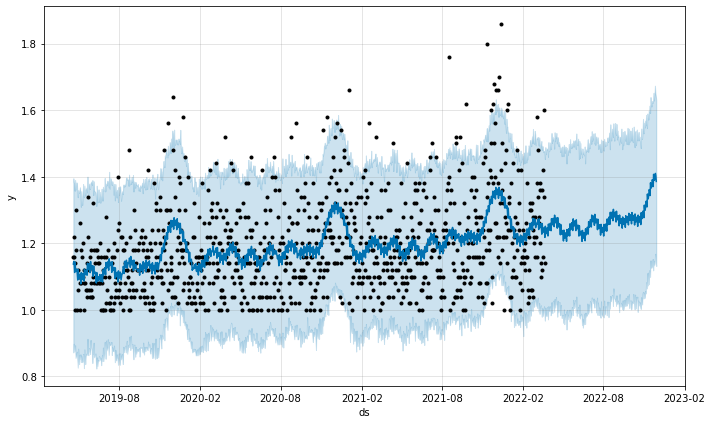

In [25]:
fig1 = m.plot(forecast_1, uncertainty=True)

### Inverse scaling of the Output

In [26]:
float_array1 = forecast_df['yhat'].values.astype(float).reshape(-1,1)
#min_max_scaler = preprocessing.MinMaxScaler()
#scaled_array = min_max_scaler.fit_transform(float_array1)
inv_yhat = scaler.inverse_transform(float_array1)
forecast_df['inv_y_hat']=inv_yhat
print(forecast_df)

             ds      yhat    inv_y_hat
1006 2022-03-23  1.251282  1223.384923
1007 2022-03-24  1.230898  1137.773534
1008 2022-03-25  1.228922  1129.472589
1009 2022-03-26  1.235159  1155.667559
1010 2022-03-27  1.246540  1203.468594
...         ...       ...          ...
1253 2022-11-25  1.389811  1805.207849
1254 2022-11-26  1.397613  1837.974314
1255 2022-11-27  1.409991  1889.961568
1256 2022-11-28  1.403223  1861.536185
1257 2022-11-29  1.385927  1788.892597

[252 rows x 3 columns]


In [27]:

float_array_test = df_test['y'].values.astype(float).reshape(-1,1)
#min_max_scaler = preprocessing.MinMaxScaler()
#scaled_array = min_max_scaler.fit_transform(float_array1)
inv_yhat_test = scaler.inverse_transform(float_array_test)
df_test['inv_y_test']=inv_yhat_test
print(df_test)

             ds     y   inv_y_test
1006 2022-03-23  1.34  1595.999747
1007 2022-03-24  1.18   923.999880
1008 2022-03-25  1.32  1511.999826
1009 2022-03-26  1.26  1260.000064
1010 2022-03-27  1.24  1176.000143
...         ...   ...          ...
1253 2022-11-30  1.62  2771.999639
1254 2022-12-01  1.22  1092.000222
1255 2022-12-02  1.66  2939.999981
1256 2022-12-03  1.30  1427.999905
1257 2022-12-04  1.66  2939.999981

[252 rows x 3 columns]


#### Merge the inverse transform data with the actual ones

In [28]:
df_forecast_actual = pd.merge(left = forecast_df,right =  df_test , how = 'left', left_on = 'ds',right_on = 'ds')


In [29]:
df_forecast_actual_compare = df_forecast_actual[['ds','inv_y_hat','inv_y_test']]
print(df_forecast_actual_compare)

            ds    inv_y_hat   inv_y_test
0   2022-03-23  1223.384923  1595.999747
1   2022-03-24  1137.773534   923.999880
2   2022-03-25  1129.472589  1511.999826
3   2022-03-26  1155.667559  1260.000064
4   2022-03-27  1203.468594  1176.000143
..         ...          ...          ...
247 2022-11-25  1805.207849  3023.999902
248 2022-11-26  1837.974314  2939.999981
249 2022-11-27  1889.961568  1176.000143
250 2022-11-28  1861.536185  4368.000137
251 2022-11-29  1788.892597  2939.999981

[252 rows x 3 columns]


#### Actual vs Prediction Graph 

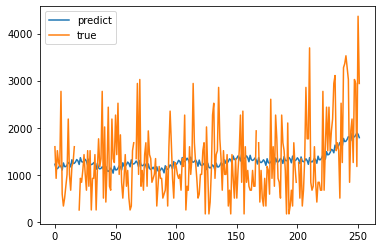

In [30]:
pyplot.plot(df_forecast_actual_compare['inv_y_hat'], label='predict')
pyplot.plot(df_forecast_actual_compare['inv_y_test'], label='true')
pyplot.legend()
pyplot.show()

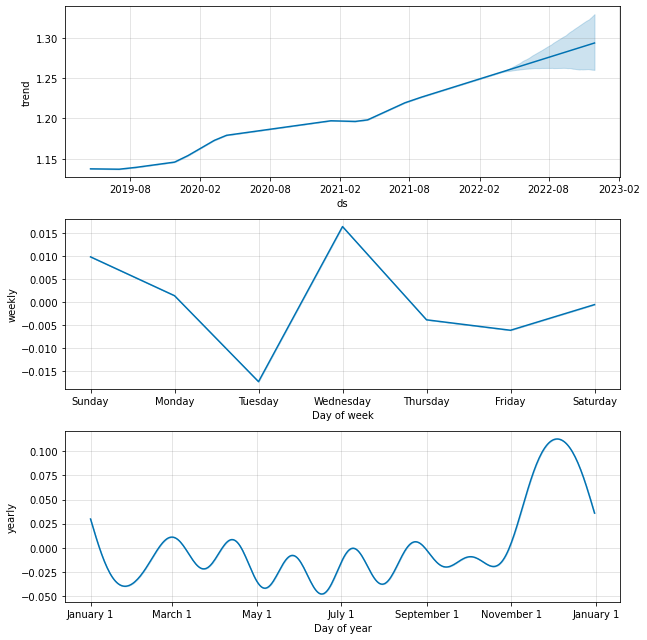

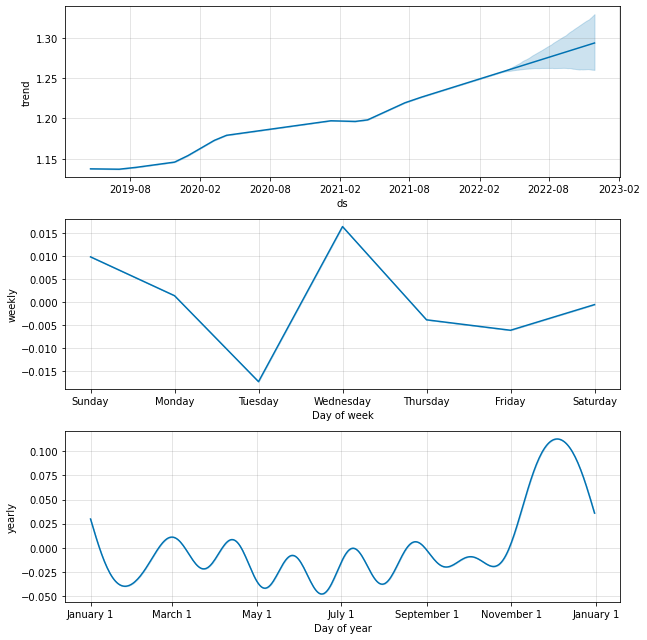

In [31]:
m.plot_components(forecast_1)

## Multivariate Analysis
### For one product and Pack Size combination

### Selecting the required Variable from the data

In [33]:
df14_training_multivariate = df14[['InvoiceDate','Revenue','Price','Quantity','Pack_Size_Code','In_Store_Promotion_Flag','Online_Promotion_Flag','Shelf_Space_Code']]
df14_training_multivariate = df14_training_multivariate.groupby('InvoiceDate')[['Revenue','Price','Quantity','Pack_Size_Code','In_Store_Promotion_Flag','Online_Promotion_Flag','Shelf_Space_Code']].sum()
df14_training_multivariate.reset_index(inplace=True)
print(df14_training_multivariate)

     InvoiceDate  Revenue  Price  Quantity  Pack_Size_Code  \
0     2019-04-20      840    252        10               6   
1     2019-04-21     1092    420        13              10   
2     2019-04-22      840    252        10               6   
3     2019-04-23      756    252         9               6   
4     2019-04-24      168     84         2               2   
...          ...      ...    ...       ...             ...   
1253  2022-11-30     2772    924        33              22   
1254  2022-12-01     1092    336        13               8   
1255  2022-12-02     2940    924        35              22   
1256  2022-12-03     1428    420        17              10   
1257  2022-12-04     2940   1008        35              24   

      In_Store_Promotion_Flag  Online_Promotion_Flag  Shelf_Space_Code  
0                           2                      1                 5  
1                           1                      2                 9  
2                           2       

#### Normalizing the Data

In [34]:
values = df14_training_multivariate['Revenue'].values.astype('float32').reshape(-1,1)

scaler = MinMaxScaler(feature_range=(1, 2))
scaled = scaler.fit_transform(values)
df14_training_multivariate['Scaled_Revenue']=scaled

print(df14_training_multivariate)

     InvoiceDate  Revenue  Price  Quantity  Pack_Size_Code  \
0     2019-04-20      840    252        10               6   
1     2019-04-21     1092    420        13              10   
2     2019-04-22      840    252        10               6   
3     2019-04-23      756    252         9               6   
4     2019-04-24      168     84         2               2   
...          ...      ...    ...       ...             ...   
1253  2022-11-30     2772    924        33              22   
1254  2022-12-01     1092    336        13               8   
1255  2022-12-02     2940    924        35              22   
1256  2022-12-03     1428    420        17              10   
1257  2022-12-04     2940   1008        35              24   

      In_Store_Promotion_Flag  Online_Promotion_Flag  Shelf_Space_Code  \
0                           2                      1                 5   
1                           1                      2                 9   
2                           2    

In [35]:
values = df14_training_multivariate['Price'].values.astype('float32').reshape(-1,1)

scaler = MinMaxScaler(feature_range=(1, 2))
scaled = scaler.fit_transform(values)
df14_training_multivariate['Scaled_Price']=scaled

print(df14_training_multivariate)

     InvoiceDate  Revenue  Price  Quantity  Pack_Size_Code  \
0     2019-04-20      840    252        10               6   
1     2019-04-21     1092    420        13              10   
2     2019-04-22      840    252        10               6   
3     2019-04-23      756    252         9               6   
4     2019-04-24      168     84         2               2   
...          ...      ...    ...       ...             ...   
1253  2022-11-30     2772    924        33              22   
1254  2022-12-01     1092    336        13               8   
1255  2022-12-02     2940    924        35              22   
1256  2022-12-03     1428    420        17              10   
1257  2022-12-04     2940   1008        35              24   

      In_Store_Promotion_Flag  Online_Promotion_Flag  Shelf_Space_Code  \
0                           2                      1                 5   
1                           1                      2                 9   
2                           2    

In [37]:
values = df14_training_multivariate['Quantity'].values.astype('float32').reshape(-1,1)

scaler = MinMaxScaler(feature_range=(1, 2))
scaled = scaler.fit_transform(values)
df14_training_multivariate['Scaled_Qty']=scaled

print(df14_training_multivariate)

     InvoiceDate  Revenue  Price  Quantity  Pack_Size_Code  \
0     2019-04-20      840    252        10               6   
1     2019-04-21     1092    420        13              10   
2     2019-04-22      840    252        10               6   
3     2019-04-23      756    252         9               6   
4     2019-04-24      168     84         2               2   
...          ...      ...    ...       ...             ...   
1253  2022-11-30     2772    924        33              22   
1254  2022-12-01     1092    336        13               8   
1255  2022-12-02     2940    924        35              22   
1256  2022-12-03     1428    420        17              10   
1257  2022-12-04     2940   1008        35              24   

      In_Store_Promotion_Flag  Online_Promotion_Flag  Shelf_Space_Code  \
0                           2                      1                 5   
1                           1                      2                 9   
2                           2    

### Renaming the Variables as required by the model

In [38]:
df14_training_multivatiate_prophet = df14_training_multivariate[['InvoiceDate','Scaled_Revenue','Scaled_Price','Scaled_Qty','Pack_Size_Code','In_Store_Promotion_Flag','Online_Promotion_Flag','Shelf_Space_Code']]
df14_training_multivatiate_prophet.columns =  ['ds','y','VT1','VT2','VT3','VT4','VT5','VT6']
print(df14_training_multivatiate_prophet)

             ds     y       VT1   VT2  VT3  VT4  VT5  VT6
0    2019-04-20  1.16  1.142857  1.16    6    2    1    5
1    2019-04-21  1.22  1.285714  1.22   10    1    2    9
2    2019-04-22  1.16  1.142857  1.16    6    2    3    7
3    2019-04-23  1.14  1.142857  1.14    6    1    2    8
4    2019-04-24  1.00  1.000000  1.00    2    1    1    2
...         ...   ...       ...   ...  ...  ...  ...  ...
1253 2022-11-30  1.62  1.714286  1.62   22    4    9   22
1254 2022-12-01  1.22  1.214286  1.22    8    2    1    8
1255 2022-12-02  1.66  1.714286  1.66   22    5    4   20
1256 2022-12-03  1.30  1.285714  1.30   10    2    0    9
1257 2022-12-04  1.66  1.785714  1.66   24    8    3   20

[1258 rows x 8 columns]


#### Train Test Split

In [39]:
 
test_percentage = .2
test_size = round(df14_training_multivatiate_prophet.shape[0] * test_percentage )


df_train_mv = df14_training_multivatiate_prophet[:-test_size]
df_test_mv = df14_training_multivatiate_prophet[-test_size:]

#df_train = df_train[['ds','y','cap']]
#df_test = df_test[['ds','y','cap']]

print(df_train_mv.shape)

print(df_test_mv.shape)


(1006, 8)
(252, 8)


#### Hyperparameter Tuning

In [40]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

mape = []
rmse = []
for params in all_params:
    m = Prophet(**params,interval_width=0.95).fit(df_train_mv)
    future = m.make_future_dataframe(periods=test_size)
    forecast_1 = m.predict(future)
    forecast_df = forecast_1[['ds', 'yhat']].tail( )
    y_actual = df_test_mv['y']
    y_predicted = forecast_df['yhat']
    

    
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 

    RMSE = math.sqrt(MSE)
    
    def calculate_mape(actual, pred): 
        actual, pred = np.array(actual), np.array(pred)
        return np.mean(np.abs((actual - pred) / actual)) * 100
    
    #mape_value = calculate_mape(y_actual,y_predicted)
    print(mape_value)
    print(RMSE)
    mape.append(mape_value)
    rmse.append(RMSE)
    

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
tuning_results['rmse'] = rmse
#print(tuning_results)


15:30:06 - cmdstanpy - INFO - Chain [1] start processing
15:30:06 - cmdstanpy - INFO - Chain [1] done processing
15:30:06 - cmdstanpy - INFO - Chain [1] start processing


10.944332576572153
0.2569606511911065


15:30:06 - cmdstanpy - INFO - Chain [1] done processing
15:30:07 - cmdstanpy - INFO - Chain [1] start processing


10.944332576572153
0.23167144498902195


15:30:07 - cmdstanpy - INFO - Chain [1] done processing
15:30:08 - cmdstanpy - INFO - Chain [1] start processing


10.944332576572153
0.23325227084399627


15:30:08 - cmdstanpy - INFO - Chain [1] done processing
15:30:09 - cmdstanpy - INFO - Chain [1] start processing


10.944332576572153
0.2480803299256351


15:30:09 - cmdstanpy - INFO - Chain [1] done processing
15:30:10 - cmdstanpy - INFO - Chain [1] start processing


10.944332576572153
0.22810088496162875


15:30:10 - cmdstanpy - INFO - Chain [1] done processing
15:30:11 - cmdstanpy - INFO - Chain [1] start processing


10.944332576572153
0.2249037275938222


15:30:11 - cmdstanpy - INFO - Chain [1] done processing
15:30:12 - cmdstanpy - INFO - Chain [1] start processing


10.944332576572153
0.2248301101800129


15:30:12 - cmdstanpy - INFO - Chain [1] done processing
15:30:12 - cmdstanpy - INFO - Chain [1] start processing


10.944332576572153
0.22375752316502606


15:30:12 - cmdstanpy - INFO - Chain [1] done processing
15:30:13 - cmdstanpy - INFO - Chain [1] start processing


10.944332576572153
0.22140663802090277


15:30:13 - cmdstanpy - INFO - Chain [1] done processing
15:30:14 - cmdstanpy - INFO - Chain [1] start processing


10.944332576572153
0.2196749812052972


15:30:14 - cmdstanpy - INFO - Chain [1] done processing
15:30:15 - cmdstanpy - INFO - Chain [1] start processing


10.944332576572153
0.21980338260852375


15:30:15 - cmdstanpy - INFO - Chain [1] done processing


10.944332576572153
0.2192000685479708


15:30:16 - cmdstanpy - INFO - Chain [1] start processing
15:30:16 - cmdstanpy - INFO - Chain [1] done processing


10.944332576572153
0.21538939980842908


15:30:17 - cmdstanpy - INFO - Chain [1] start processing
15:30:17 - cmdstanpy - INFO - Chain [1] done processing
15:30:18 - cmdstanpy - INFO - Chain [1] start processing


10.944332576572153
0.21611107366605337


15:30:18 - cmdstanpy - INFO - Chain [1] done processing
15:30:19 - cmdstanpy - INFO - Chain [1] start processing


10.944332576572153
0.21594952494097933


15:30:19 - cmdstanpy - INFO - Chain [1] done processing


10.944332576572153
0.21578171472563884


In [42]:
print(tuning_results)
#Prediction Chart 

    changepoint_prior_scale  seasonality_prior_scale       mape      rmse
0                     0.001                     0.01  10.944333  0.256961
1                     0.001                     0.10  10.944333  0.231671
2                     0.001                     1.00  10.944333  0.233252
3                     0.001                    10.00  10.944333  0.248080
4                     0.010                     0.01  10.944333  0.228101
5                     0.010                     0.10  10.944333  0.224904
6                     0.010                     1.00  10.944333  0.224830
7                     0.010                    10.00  10.944333  0.223758
8                     0.100                     0.01  10.944333  0.221407
9                     0.100                     0.10  10.944333  0.219675
10                    0.100                     1.00  10.944333  0.219803
11                    0.100                    10.00  10.944333  0.219200
12                    0.500           

#### Prediction based on best parameters

In [44]:
m = Prophet(changepoint_prior_scale=0.500,seasonality_prior_scale=10.00 ,interval_width=0.95,yearly_seasonality=True).fit(df_train_mv)
future = m.make_future_dataframe(periods=test_size)
forecast_1 = m.predict(future)
forecast_df = forecast_1[['ds', 'yhat']].tail(test_size)
y_actual = df_test_mv['y']
y_predicted = forecast_df['yhat']


MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 

RMSE = math.sqrt(MSE)
def calculate_mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
    
mape_value = calculate_mape(y_actual,y_predicted)

15:51:37 - cmdstanpy - INFO - Chain [1] start processing
15:51:37 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
print(RMSE)
print(mape_value)


0.17891582709106257
10.944332576572153


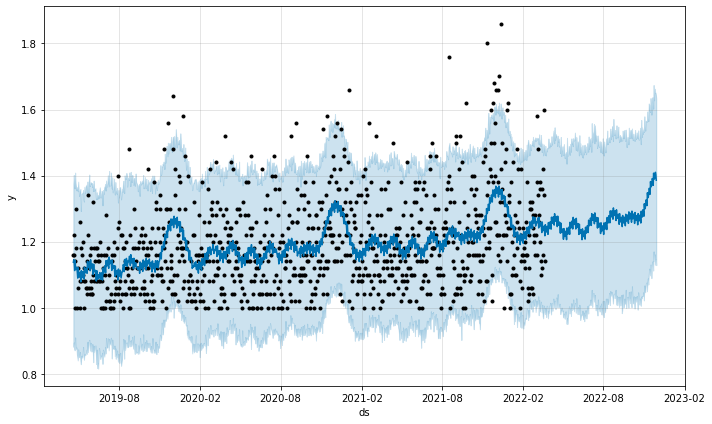

In [46]:
fig1 = m.plot(forecast_1, uncertainty=True)

### Inverse Transform the Normalized data

In [47]:
float_array1 = forecast_df['yhat'].values.astype(float).reshape(-1,1)
#min_max_scaler = preprocessing.MinMaxScaler()
#scaled_array = min_max_scaler.fit_transform(float_array1)
inv_yhat = scaler.inverse_transform(float_array1)
forecast_df['inv_y_hat']=inv_yhat
print(forecast_df)

             ds      yhat  inv_y_hat
1006 2022-03-23  1.251282  14.564106
1007 2022-03-24  1.230898  13.544923
1008 2022-03-25  1.228922  13.446102
1009 2022-03-26  1.235159  13.757947
1010 2022-03-27  1.246540  14.327007
...         ...       ...        ...
1253 2022-11-25  1.389811  21.490570
1254 2022-11-26  1.397613  21.880647
1255 2022-11-27  1.409991  22.499543
1256 2022-11-28  1.403223  22.161145
1257 2022-11-29  1.385927  21.296341

[252 rows x 3 columns]


In [48]:
float_array_test = df_test_mv['y'].values.astype(float).reshape(-1,1)
#min_max_scaler = preprocessing.MinMaxScaler()
#scaled_array = min_max_scaler.fit_transform(float_array1)
inv_yhat_test = scaler.inverse_transform(float_array_test)
df_test_mv['inv_y_test']=inv_yhat_test
print(df_test_mv)

             ds     y       VT1   VT2  VT3  VT4  VT5  VT6  inv_y_test
1006 2022-03-23  1.34  1.357143  1.34   12    4    2   12   18.999997
1007 2022-03-24  1.18  1.214286  1.18    8    2    1    7   10.999999
1008 2022-03-25  1.32  1.357143  1.32   12    2    4   10   17.999998
1009 2022-03-26  1.26  1.285714  1.26   10    2    3   10   15.000001
1010 2022-03-27  1.24  1.285714  1.24   10    3    4    7   14.000002
...         ...   ...       ...   ...  ...  ...  ...  ...         ...
1253 2022-11-30  1.62  1.714286  1.62   22    4    9   22   32.999996
1254 2022-12-01  1.22  1.214286  1.22    8    2    1    8   13.000003
1255 2022-12-02  1.66  1.714286  1.66   22    5    4   20   35.000000
1256 2022-12-03  1.30  1.285714  1.30   10    2    0    9   16.999999
1257 2022-12-04  1.66  1.785714  1.66   24    8    3   20   35.000000

[252 rows x 9 columns]


In [49]:
df_forecast_actual = pd.merge(left = forecast_df,right =  df_test_mv , how = 'left', left_on = 'ds',right_on = 'ds')
df_forecast_actual_compare = df_forecast_actual[['ds','inv_y_hat','inv_y_test']]
print(df_forecast_actual_compare)


            ds  inv_y_hat  inv_y_test
0   2022-03-23  14.564106   18.999997
1   2022-03-24  13.544923   10.999999
2   2022-03-25  13.446102   17.999998
3   2022-03-26  13.757947   15.000001
4   2022-03-27  14.327007   14.000002
..         ...        ...         ...
247 2022-11-25  21.490570   35.999999
248 2022-11-26  21.880647   35.000000
249 2022-11-27  22.499543   14.000002
250 2022-11-28  22.161145   52.000002
251 2022-11-29  21.296341   35.000000

[252 rows x 3 columns]


#### Actual vs Forecast Graph

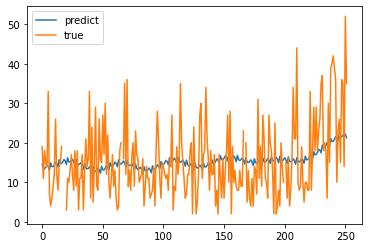

In [50]:
pyplot.plot(df_forecast_actual_compare['inv_y_hat'], label='predict')
pyplot.plot(df_forecast_actual_compare['inv_y_test'], label='true')
pyplot.legend()
pyplot.show()

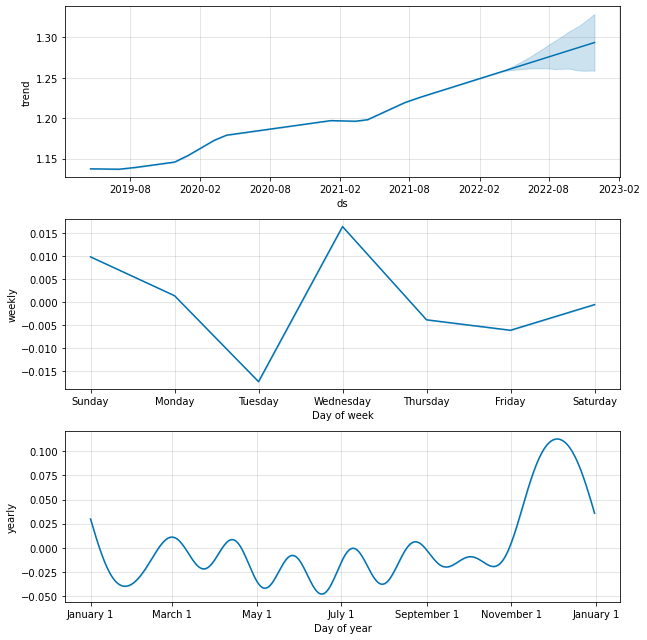

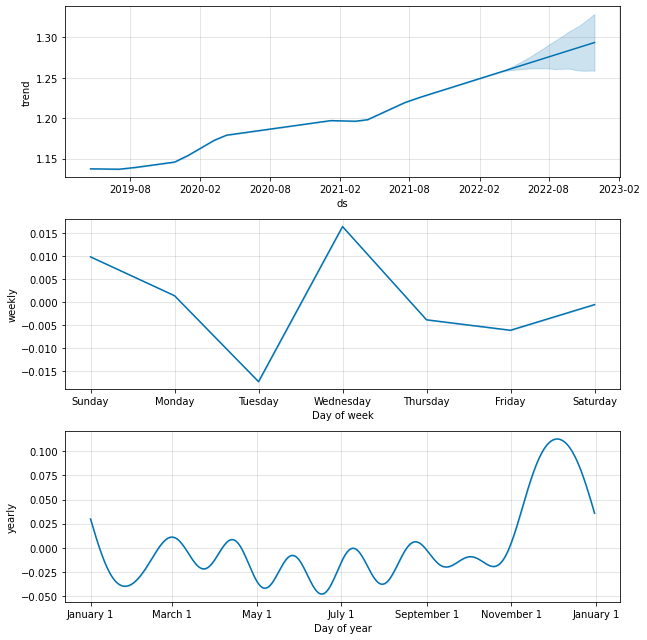

In [51]:
m.plot_components(forecast_1)

## Finalized Forecast for Products

### Hyperparameter Tuning for all the differnt parameters

In [32]:
df_all_training_multivariate = df_all_one_hot
#print(df_all_training_multivariate)
values = df_all_training_multivariate['Revenue'].values.astype('float32').reshape(-1,1)
scaler_1 = MinMaxScaler(feature_range=(1, 2))
scaled = scaler_1.fit_transform(values)
df_all_training_multivariate['Scaled_Revenue']=scaled
#print(df_all_training_multivariate)
values = df_all_training_multivariate['Price'].values.astype('float32').reshape(-1,1)
scaler_2 = MinMaxScaler(feature_range=(1, 2))
scaled = scaler_2.fit_transform(values)
df_all_training_multivariate['Scaled_Price']=scaled
#print(df_all_training_multivariate)

values = df_all_training_multivariate['Quantity'].values.astype('float32').reshape(-1,1)
scaler_3 = MinMaxScaler(feature_range=(1, 2))
scaled = scaler_3.fit_transform(values)
df_all_training_multivariate['Scaled_Qty']=scaled
#print(df_all_training_multivariate.head())


df_all_training_multivatiate_prophet = df_all_training_multivariate[['InvoiceDate','Scaled_Revenue','Scaled_Price','Scaled_Qty','In_Store_Promotion_Flag','Online_Promotion_Flag','Pack_Size_Code_1','Pack_Size_Code_2','Pack_Size_Code_3','Pack_Size_Code_4','Shelf_Space_Code_1','Shelf_Space_Code_2','Shelf_Space_Code_3']]
df_all_training_multivatiate_prophet.columns =  ['ds','y','VT1','VT2','VT3','VT4','VT5','VT6','VT7','VT8','VT9','VT10','VT11']
#print(df_all_training_multivatiate_prophet.head())

test_percentage = .2
test_size = round(df_all_training_multivatiate_prophet.shape[0] * test_percentage )
df_train_mv_all = df_all_training_multivatiate_prophet[:-test_size]
df_test_mv_all = df_all_training_multivatiate_prophet[-test_size:]

print(df_train_mv_all.shape)
print(df_test_mv_all.shape)

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

mape = []
rmse = []
for params in all_params:
    m = Prophet(**params,interval_width=0.95).fit(df_train_mv_all)
    future = m.make_future_dataframe(periods=test_size)
    forecast_1 = m.predict(future)
    forecast_df = forecast_1[['ds', 'yhat']].tail(test_size)
    y_actual = df_test_mv_all['y']
    y_predicted = forecast_df['yhat']
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
    RMSE = math.sqrt(MSE)
    
    
    def calculate_mape(actual, pred): 
        actual, pred = np.array(actual), np.array(pred)
        return np.mean(np.abs((actual - pred) / actual)) * 100
    
    mape_value = calculate_mape(y_actual,y_predicted)
    print(mape_value)
    print(RMSE)
    mape.append(mape_value)
    rmse.append(RMSE)
       
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
tuning_results['rmse'] = rmse
#print(tuning_results)



17:11:19 - cmdstanpy - INFO - Chain [1] start processing


(1060, 13)
(265, 13)


17:11:19 - cmdstanpy - INFO - Chain [1] done processing
17:11:20 - cmdstanpy - INFO - Chain [1] start processing


7.609158314443381
0.13816887469037575


17:11:20 - cmdstanpy - INFO - Chain [1] done processing


7.573339617254579
0.13456548819724684


17:11:21 - cmdstanpy - INFO - Chain [1] start processing
17:11:21 - cmdstanpy - INFO - Chain [1] done processing
17:11:22 - cmdstanpy - INFO - Chain [1] start processing


7.574382338012009
0.13492766901619738


17:11:22 - cmdstanpy - INFO - Chain [1] done processing


7.589672706462886
0.1375237507936084


17:11:23 - cmdstanpy - INFO - Chain [1] start processing
17:11:23 - cmdstanpy - INFO - Chain [1] done processing


7.641334236747972
0.13973230360181668


17:11:24 - cmdstanpy - INFO - Chain [1] start processing
17:11:24 - cmdstanpy - INFO - Chain [1] done processing


7.629383492152825
0.13923577217497624


17:11:25 - cmdstanpy - INFO - Chain [1] start processing
17:11:25 - cmdstanpy - INFO - Chain [1] done processing


7.636609648377295
0.1394505659615124


17:11:26 - cmdstanpy - INFO - Chain [1] start processing
17:11:26 - cmdstanpy - INFO - Chain [1] done processing
17:11:27 - cmdstanpy - INFO - Chain [1] start processing


7.632923312753337
0.13934209891073068


17:11:27 - cmdstanpy - INFO - Chain [1] done processing
17:11:28 - cmdstanpy - INFO - Chain [1] start processing


7.610626104430714
0.13347141782285354


17:11:28 - cmdstanpy - INFO - Chain [1] done processing
17:11:29 - cmdstanpy - INFO - Chain [1] start processing


7.550777745145281
0.13324943095573658


17:11:29 - cmdstanpy - INFO - Chain [1] done processing


7.548183735674679
0.13320846935783834


17:11:30 - cmdstanpy - INFO - Chain [1] start processing
17:11:30 - cmdstanpy - INFO - Chain [1] done processing


7.549733245310561
0.13306576712969342


17:11:32 - cmdstanpy - INFO - Chain [1] start processing
17:11:33 - cmdstanpy - INFO - Chain [1] done processing


7.612079379599058
0.1326197535245735


17:11:34 - cmdstanpy - INFO - Chain [1] start processing
17:11:34 - cmdstanpy - INFO - Chain [1] done processing


7.4972019051488985
0.13240449846124255


17:11:36 - cmdstanpy - INFO - Chain [1] start processing
17:11:36 - cmdstanpy - INFO - Chain [1] done processing


7.497202394925827
0.13329900590284421


17:11:37 - cmdstanpy - INFO - Chain [1] start processing
17:11:38 - cmdstanpy - INFO - Chain [1] done processing


7.488030277531772
0.13281518357889027


#### Results of Hyperparameter tuning

In [33]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale      mape      rmse
0                     0.001                     0.01  7.609158  0.138169
1                     0.001                     0.10  7.573340  0.134565
2                     0.001                     1.00  7.574382  0.134928
3                     0.001                    10.00  7.589673  0.137524
4                     0.010                     0.01  7.641334  0.139732
5                     0.010                     0.10  7.629383  0.139236
6                     0.010                     1.00  7.636610  0.139451
7                     0.010                    10.00  7.632923  0.139342
8                     0.100                     0.01  7.610626  0.133471
9                     0.100                     0.10  7.550778  0.133249
10                    0.100                     1.00  7.548184  0.133208
11                    0.100                    10.00  7.549733  0.133066
12                    0.500                     0.0

## Final Forecasting based on Hyperparameter Tuning Results

In [34]:
m = Prophet(changepoint_prior_scale=0.500,seasonality_prior_scale=10.00 ,interval_width=0.95,yearly_seasonality=True).fit(df_train_mv_all)
future = m.make_future_dataframe(periods=test_size)
forecast_1 = m.predict(future)
forecast_df = forecast_1[['ds', 'yhat']].tail(test_size)
y_actual = df_test_mv_all['y']
y_predicted = forecast_df['yhat']


MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 

RMSE = math.sqrt(MSE)
def calculate_mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
    
mape_value = calculate_mape(y_actual,y_predicted)
print(mape_value)
print(RMSE)



17:19:06 - cmdstanpy - INFO - Chain [1] start processing
17:19:06 - cmdstanpy - INFO - Chain [1] done processing


7.488030277531772
0.13281518357889027
(265,)
(265,)


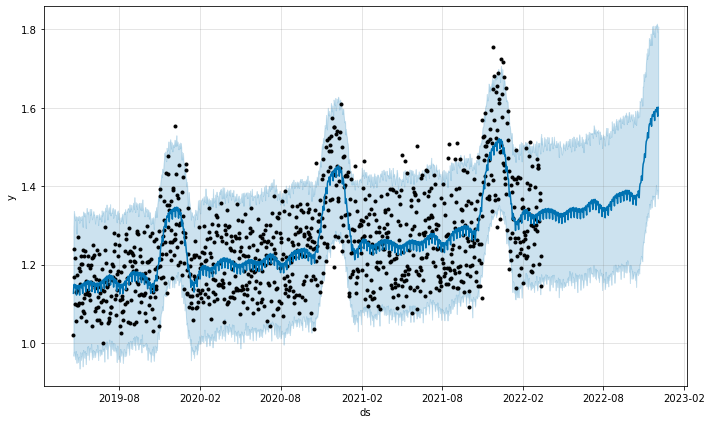

In [36]:
fig1 = m.plot(forecast_1, uncertainty=True)

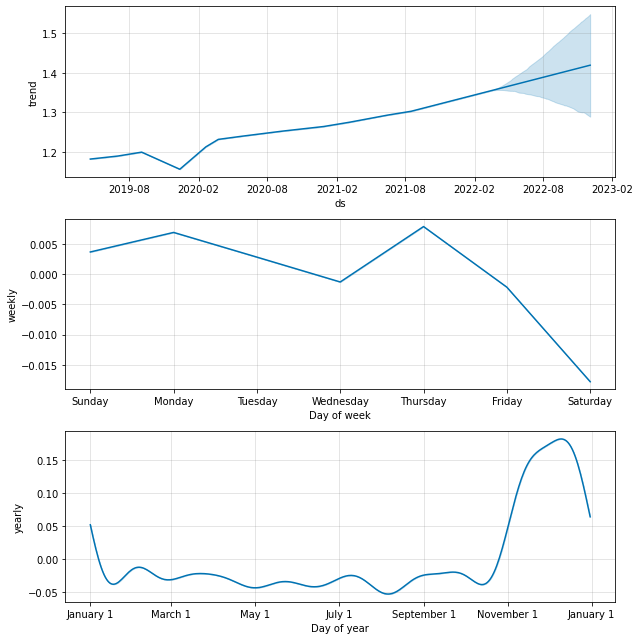

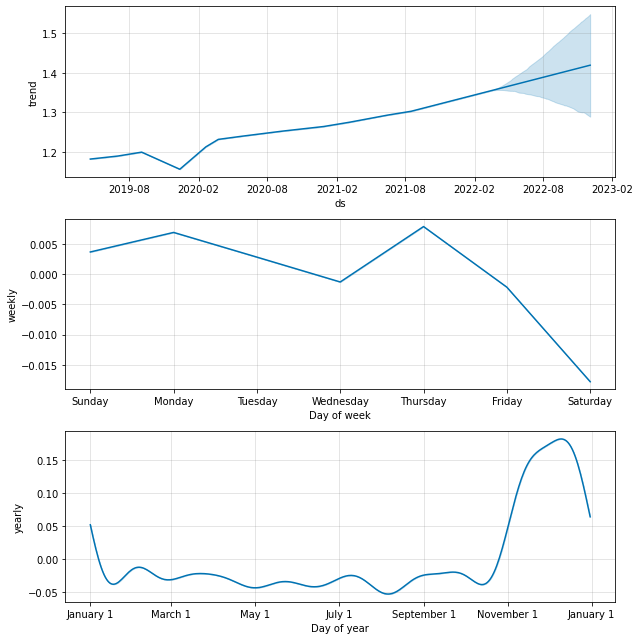

In [37]:
m.plot_components(forecast_1)

## Iterate by decreasing the number of input Variables

#### Create a list with all the different combinations of Variables 

In [40]:
list_all = [['ds','y','VT1','VT2','VT3','VT4','VT5','VT6','VT7','VT8','VT9','VT10','VT11'],['ds','y','VT1','VT2','VT3','VT4','VT5','VT6','VT7','VT8','VT9','VT10'],['ds','y','VT1','VT2','VT3','VT4','VT5','VT6','VT7','VT8','VT9'],['ds','y','VT1','VT2','VT3','VT4','VT5','VT6','VT7','VT8'],['ds','y','VT1','VT2','VT3','VT4','VT5','VT6','VT7'],['ds','y','VT1','VT2','VT3','VT4','VT5','VT6'],['ds','y','VT1','VT2','VT3','VT4','VT5'],['ds','y','VT1','VT2','VT3','VT4'],['ds','y','VT1','VT2','VT3'],['ds','y','VT1','VT2'],['ds','y','VT1'],['ds','y']]
print(len(list_all))    

12


In [48]:
count_column = []
column_wise_mape = []
column_wise_rmse = []
for i in list_all:
    df_all_training_multivatiate_prophet_loop = df_all_training_multivatiate_prophet[i]
    #print(df_all_training_multivatiate_prophet_loop)
    count_column.append(df_all_training_multivatiate_prophet_loop.shape[1])
    test_percentage = .2
    test_size = round(df_all_training_multivatiate_prophet_loop.shape[0] * test_percentage )
    df_train_mv_all = df_all_training_multivatiate_prophet_loop[:-test_size]
    df_test_mv_all = df_all_training_multivatiate_prophet_loop[-test_size:]
    print(df_train_mv_all.shape)
    print(df_test_mv_all.shape)
    m = Prophet(changepoint_prior_scale=0.500,seasonality_prior_scale=10.00 ,interval_width=0.95,yearly_seasonality=True).fit(df_train_mv_all)
    future = m.make_future_dataframe(periods=test_size)
    forecast_1 = m.predict(future)
    forecast_df = forecast_1[['ds', 'yhat']].tail(test_size)
    y_actual = df_test_mv_all['y']
    y_predicted = forecast_df['yhat']


    MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 

    RMSE = math.sqrt(MSE)
    def calculate_mape(actual, pred): 
        actual, pred = np.array(actual), np.array(pred)
        return np.mean(np.abs((actual - pred) / actual)) * 100
    
    mape_value = calculate_mape(y_actual,y_predicted)
    column_wise_mape.append(mape_value)
    column_wise_rmse.append(RMSE)
    print(mape_value)
    print(RMSE)




00:23:23 - cmdstanpy - INFO - Chain [1] start processing


(1060, 13)
(265, 13)


00:23:23 - cmdstanpy - INFO - Chain [1] done processing
00:23:24 - cmdstanpy - INFO - Chain [1] start processing


7.488030277531772
0.13281518357889027
(1060, 12)
(265, 12)


00:23:24 - cmdstanpy - INFO - Chain [1] done processing
00:23:24 - cmdstanpy - INFO - Chain [1] start processing


7.488030277531772
0.13281518357889027
(1060, 11)
(265, 11)


00:23:25 - cmdstanpy - INFO - Chain [1] done processing
00:23:25 - cmdstanpy - INFO - Chain [1] start processing


7.488030277531772
0.13281518357889027
(1060, 10)
(265, 10)


00:23:25 - cmdstanpy - INFO - Chain [1] done processing
00:23:26 - cmdstanpy - INFO - Chain [1] start processing


7.488030277531772
0.13281518357889027
(1060, 9)
(265, 9)


00:23:26 - cmdstanpy - INFO - Chain [1] done processing
00:23:27 - cmdstanpy - INFO - Chain [1] start processing


7.488030277531772
0.13281518357889027
(1060, 8)
(265, 8)


00:23:27 - cmdstanpy - INFO - Chain [1] done processing
00:23:28 - cmdstanpy - INFO - Chain [1] start processing


7.488030277531772
0.13281518357889027
(1060, 7)
(265, 7)


00:23:28 - cmdstanpy - INFO - Chain [1] done processing
00:23:29 - cmdstanpy - INFO - Chain [1] start processing


7.488030277531772
0.13281518357889027
(1060, 6)
(265, 6)


00:23:29 - cmdstanpy - INFO - Chain [1] done processing
00:23:30 - cmdstanpy - INFO - Chain [1] start processing


7.488030277531772
0.13281518357889027
(1060, 5)
(265, 5)


00:23:30 - cmdstanpy - INFO - Chain [1] done processing
00:23:31 - cmdstanpy - INFO - Chain [1] start processing


7.488030277531772
0.13281518357889027
(1060, 4)
(265, 4)


00:23:31 - cmdstanpy - INFO - Chain [1] done processing
00:23:31 - cmdstanpy - INFO - Chain [1] start processing


7.488030277531772
0.13281518357889027
(1060, 3)
(265, 3)


00:23:32 - cmdstanpy - INFO - Chain [1] done processing
00:23:32 - cmdstanpy - INFO - Chain [1] start processing


7.488030277531772
0.13281518357889027
(1060, 2)
(265, 2)


00:23:33 - cmdstanpy - INFO - Chain [1] done processing


7.488030277531772
0.13281518357889027
[7.488030277531772, 7.488030277531772, 7.488030277531772, 7.488030277531772, 7.488030277531772, 7.488030277531772, 7.488030277531772, 7.488030277531772, 7.488030277531772, 7.488030277531772, 7.488030277531772, 7.488030277531772]


### Results of the Iterative multiple model approach

In [46]:
columns_wise_accuracy = pd.DataFrame(list(zip(count_column,column_wise_mape,column_wise_rmse)),
                                     columns = ['Columns_Count','MAPE','RMSE'])
print(columns_wise_accuracy)                                     


    Columns_Count     MAPE      RMSE
0              13  7.48803  0.132815
1              12  7.48803  0.132815
2              11  7.48803  0.132815
3              10  7.48803  0.132815
4               9  7.48803  0.132815
5               8  7.48803  0.132815
6               7  7.48803  0.132815
7               6  7.48803  0.132815
8               5  7.48803  0.132815
9               4  7.48803  0.132815
10              3  7.48803  0.132815
11              2  7.48803  0.132815
